In [1]:
import zarr
import numpy as np
from pathlib import Path

def read_zarr_dataset(zarr_path, verbose=True):
    """
    读取Zarr数据集并打印结构信息
    
    参数:
        zarr_path (str/Path): Zarr数据集路径
        verbose (bool): 是否打印详细信息
    
    返回:
        dict: 包含所有数组和组的字典
    """
    # 转换为Path对象
    zarr_path = Path(zarr_path)
    
    if not zarr_path.exists():
        raise FileNotFoundError(f"Zarr路径不存在: {zarr_path}")
    
    # 打开Zarr数据集
    try:
        # 自动检测存储类型 (目录/DirectoryStore 或 zip/ZipStore)
        if zarr_path.is_dir():
            store = zarr.DirectoryStore(zarr_path)
        elif zarr_path.suffix == '.zip':
            store = zarr.ZipStore(zarr_path, mode='r')
        else:
            raise ValueError("不支持的Zarr存储格式，请使用目录或.zip文件")
        
        root = zarr.open(store, mode='r')
        
        if verbose:
            print(f"成功加载Zarr数据集: {zarr_path}")
            print("\n数据集结构:")
            _print_zarr_tree(root)
        
        # 转换为字典格式返回
        data_dict = _zarr_to_dict(root)
        return data_dict
        
    except Exception as e:
        raise RuntimeError(f"读取Zarr数据集失败: {str(e)}")
    finally:
        if 'store' in locals():
            store.close()

def _print_zarr_tree(group, indent=0):
    """递归打印Zarr组/数组结构"""
    prefix = '  ' * indent
    for key, item in group.items():
        if isinstance(item, zarr.core.Array):
            print(f"{prefix}├─ {key} [Array] {item.shape} {item.dtype}")
        elif isinstance(item, zarr.hierarchy.Group):
            print(f"{prefix}├─ {key} [Group]")
            _print_zarr_tree(item, indent + 1)

def _zarr_to_dict(node):
    """将Zarr组转换为Python字典"""
    result = {}
    for key, item in node.items():
        if isinstance(item, zarr.core.Array):
            # 将数组加载到内存 (小数据集) 或保持为zarr数组 (大数据集)
            if item.nbytes < 100 * 1024 * 1024:  # 小于100MB直接加载
                result[key] = np.array(item)
            else:
                result[key] = item
        elif isinstance(item, zarr.hierarchy.Group):
            result[key] = _zarr_to_dict(item)
    return result

def process_done(data):
    # 获取episode结束索引
    episode_ends = data['meta']['episode_ends'][:]
    
    # 处理done字段
    if 'done' not in data['data']:
        # 创建初始化为0的done数组
        total_steps = data['data']['action'].shape[0]
        done = np.zeros(total_steps, dtype=np.int32)
        
        # 标记episode终止位置
        for end_idx in episode_ends:
            if end_idx <= total_steps:
                done[end_idx-1] = 1
            else:
                print(f"Warning: Episode end index {end_idx} exceeds dataset size {total_steps}")
        
        # 将done数组写入数据集（需要写入权限时使用）
        # 注意：如果数据集是只读模式，这里应该在内存中创建副本
        data['data']['done'] = done
        
    return data

def process_next_obs(data):
    episode_ends = data['meta']['episode_ends'][:]  # 获取所有episode结束位置
    head_cam = data['data']['head_camera']  # 原始头摄像头数据
    next_head_cam = np.zeros_like(head_cam)  # 初始化next_head_cam
    state = data['data']['state']
    next_state = np.zeros_like(state)
    
    start_idx = 0
    for end_idx in episode_ends:
        # 处理当前episode内的数据
        episode_slice = slice(start_idx, end_idx)
        
        # 常规平移：当前episode内，next_head_cam[t] = head_cam[t+1]
        if end_idx - start_idx > 1:  # 确保episode长度>1
            next_head_cam[episode_slice][:-1] = head_cam[episode_slice][1:]
            next_state[episode_slice][:-1] = state[episode_slice][1:]
        
        # episode最后一个时间步的next_head_cam设为0（终止状态）
        next_head_cam[end_idx - 1] = 0  # -1因为end_idx是exclusive的
        next_state[end_idx - 1] = 0
        
        start_idx = end_idx  # 移动到下一个episode
    
    # 处理最后一个episode之后的数据（如果有）
    if start_idx < len(head_cam):
        next_head_cam[start_idx:-1] = head_cam[start_idx+1:]
        next_head_cam[-1] = 0  # 整个数据集的最后一个时间步
        next_state[start_idx:-1] = state[start_idx+1:]
        next_state[-1] = 0  # 整个数据集的最后一个时间步
    
    data['data']['next_head_camera'] = next_head_cam
    data['data']['next_state'] = next_state
    return data

成功加载Zarr数据集: policy/Diffusion-Policy/data/put_apple_cabinet_bc_bcq_D435_40.zarr

数据集结构:
├─ data [Group]
  ├─ action [Array] (12439, 14) float32
  ├─ apple_pose [Array] (12439, 7) float32
  ├─ cabinet_pose [Array] (12439, 7) float32
  ├─ done [Array] (12439,) int32
  ├─ head_camera [Array] (12439, 3, 240, 320) uint8
  ├─ next_head_camera [Array] (12439, 3, 240, 320) uint8
  ├─ next_state [Array] (12439, 14) float32
  ├─ reward [Array] (12439,) float32
  ├─ state [Array] (12439, 14) float32
  ├─ tcp_action [Array] (12439, 14) float32
├─ meta [Group]
  ├─ episode_ends [Array] (40,) int64
action: [-1.2319934e+00  2.0180216e+00  4.3902537e-01  1.5789876e+00
 -1.2319863e+00  1.5707947e+00 -2.0000000e-02  6.6163695e-01
  2.3036411e+00  2.3045468e+00 -1.5716940e+00  1.0569643e-05
  6.6164887e-01  1.1250000e-04]
episode_ends: [  312   624   938  1244  1553  1869  2173  2484  2798  3104  3415  3731
  4050  4365  4666  4977  5279  5586  5886  6190  6513  6816  7144  7460
  7764  8070  8382  8704 

/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.

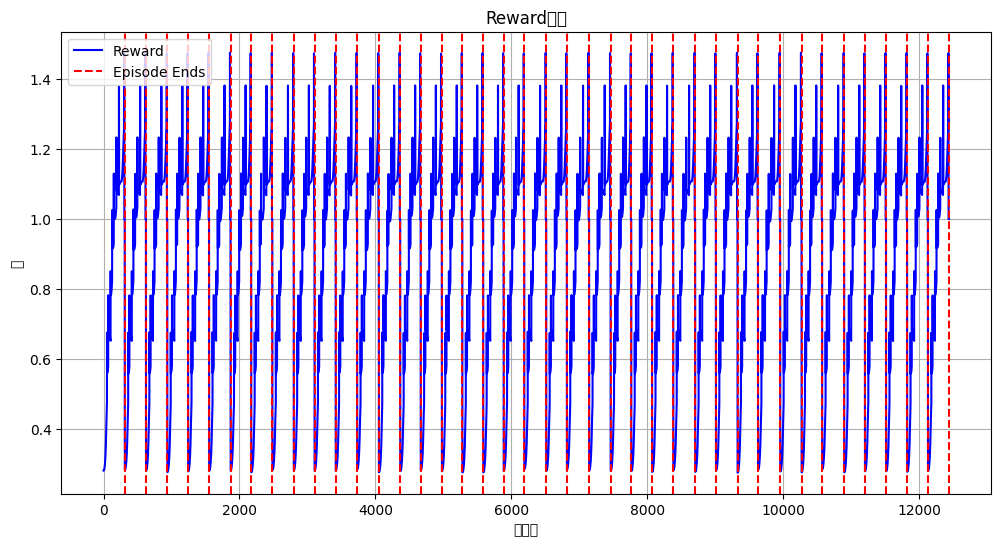

In [2]:
# 示例1: 读取目录型Zarr
import matplotlib.pyplot as plt
dataset_path = 'policy/Diffusion-Policy/data/put_apple_cabinet_bc_bcq_D435_40.zarr'  # 替换为你的路径

process_flag = False

if process_flag:
    data = zarr.open(dataset_path, mode='a')  # 'a'模式允许修改
    data = process_done(data)
    # data = process_done(data)
    data = process_next_obs(data)

# # 读取数据
data = read_zarr_dataset(dataset_path)

print("action:", data['data']['action'][200,:])
# print("state:",data['data']['state'][10,:])
# print("tcp_action:",data['data']['tcp_action'][10,:])
# print("apple_pose:",data['data']['apple_pose'][100])
# print("cabinet_pose:",data['data']['cabinet_pose'][100])

# # 示例2: 读取压缩的Zarr
# # zip_data = read_zarr_dataset("./dataset.zip")


# # 提取reward和state数据
reward_data = data['data']['reward']
# state_data = data['data']['state']
episode_ends = data['meta']['episode_ends']  # 获取episode_ends数据

print("episode_ends:",episode_ends)

m = 311
print("real_state:", data['data']['state'][m])
print("next_state:", data['data']['next_state'][m])

# print("real_head_camera:", data['data']['head_camera'][m])
# print("next_head_camera:", data['data']['next_head_camera'][m])

# print("done标记:", data['data']['done'][m])
# print("reward_{m}:",reward_data[m])


# 创建图形
plt.figure(figsize=(12, 6))

# 绘制reward数据
plt.plot(reward_data, label='Reward', color='blue')

# 在episode_ends处绘制竖线
for episode_end in episode_ends:
    plt.axvline(x=episode_end, color='red', linestyle='--', label='Episode Ends' if episode_end == episode_ends[0] else "")

# 添加图例和标题
plt.title('Reward数据')
plt.xlabel('时间步')
plt.ylabel('值')
plt.legend()
plt.grid()

# 显示图形
plt.show()


In [12]:
import pickle

# 读取pkl数据集的函数
def read_pkl_dataset(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# 示例：读取pkl数据集
pkl_file_path = 'data/put_apple_cabinet_D435_20_pkl/episode0/0.pkl'  # 替换为你的pkl文件路径
pkl_data = read_pkl_dataset(pkl_file_path)

# 打印其中的一个数据目录
print("数据目录示例:", pkl_data.keys())
print(pkl_data['observation'].keys())


数据目录示例: dict_keys(['observation', 'pointcloud', 'joint_action', 'endpose'])
dict_keys(['head_camera', 'left_camera', 'right_camera', 'front_camera'])


成功加载Zarr数据集: policy/Diffusion-Policy/data/put_apple_cabinet_bc_D435_20.zarr

数据集结构:
├─ data [Group]
  ├─ action [Array] (6060, 14) float32
  ├─ head_camera [Array] (6060, 3, 240, 320) uint8
  ├─ right_camera [Array] (6060, 3, 240, 320) uint8
  ├─ state [Array] (6060, 14) float32
  ├─ tcp_action [Array] (6060, 14) float32
├─ meta [Group]
  ├─ episode_ends [Array] (20,) int64
动作数据中的最大值: 2.3228462
TCP动作数据中的最大值: 3.141573
[ 303  606  909 1212 1515 1818 2121 2424 2727 3030 3333 3636 3939 4242
 4545 4848 5151 5454 5757 6060]
action: [-0.14526245  0.09501953  0.01627016  0.07875045 -0.14526175  0.06422811
  0.045       0.05832812  0.09895018  0.03372615  0.00664589  0.05831462
  0.00085645  0.045     ]
state: [-0.14526245  0.09501953  0.01627016  0.07875045 -0.14526175  0.06422811
  0.045       0.05832812  0.09895018  0.03372615  0.00664589  0.05831462
  0.00085645  0.045     ]
tcp_action: [-2.8726384e-01 -3.0712873e-01  9.4268614e-01 -3.0785155e+00
  1.0130930e-03  1.5713049e+00  4.5000002e-0

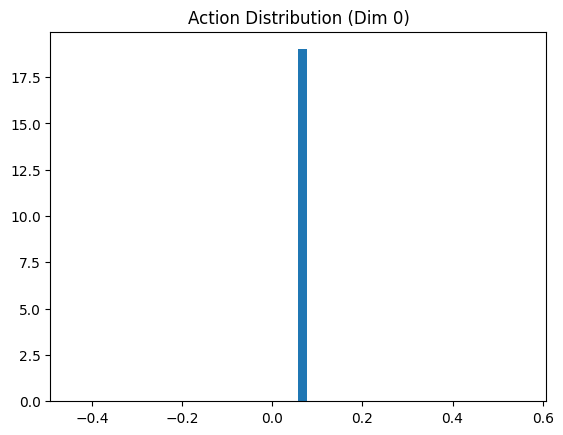

In [11]:
# dataset_path = 'policy/Diffusion-Policy/data/put_apple_cabinet_rl_D435_50.zarr'  # 替换为你的路径
dataset_path = 'policy/Diffusion-Policy/data/put_apple_cabinet_bc_D435_20.zarr'  # 替换为你的路径

data = read_zarr_dataset(dataset_path)
# rewards = data['data']['reward']
# print("Reward mean:", rewards.mean(), "std:", rewards.std())

import matplotlib.pyplot as plt
import numpy as np
actions = data['data']['action']
tcp_actions = data['data']['tcp_action']
max_action = actions.max()
max_tcp_actions = tcp_actions.max()
print("动作数据中的最大值:", max_action)
print("TCP动作数据中的最大值:", max_tcp_actions)

episode_ends = data['meta']['episode_ends']
print(episode_ends)
action_list = []
for it in episode_ends:
    m = it + 10
    if it==episode_ends[-1]:
        break
    action_list.append(actions[m,:])
    print('action:',data['data']['action'][m])
    print('state:',data['data']['state'][m])
    print('tcp_action:',data['data']['tcp_action'][m])
# 将action_list转换为numpy数组后再切片
action_array = np.array(action_list)
plt.hist(action_array[:,11], bins=50)
plt.title("Action Distribution (Dim 0)")
plt.show()


In [3]:
import torch
import argparse

def print_recursive(obj, indent=0, max_depth=3, max_items=20):
    prefix = " " * indent
    if isinstance(obj, dict):
        print(f"{prefix}Dict with {len(obj)} keys:")
        for i, (k, v) in enumerate(obj.items()):
            if i >= max_items:
                print(f"{prefix}  ... (and more)")
                break
            print(f"{prefix}  [{k}] -> ", end="")
            print_recursive(v, indent + 4, max_depth - 1)
    elif isinstance(obj, (list, tuple)):
        print(f"{prefix}{type(obj).__name__} of length {len(obj)}:")
        for i, item in enumerate(obj):
            if i >= max_items:
                print(f"{prefix}  ... (and more)")
                break
            print(f"{prefix}  [{i}] -> ", end="")
            print_recursive(item, indent + 4, max_depth - 1)
    elif isinstance(obj, torch.Tensor):
        print(f"{prefix}Tensor of shape {obj.shape}, dtype={obj.dtype}")
    else:
        print(f"{prefix}{type(obj).__name__}: {obj}")

def inspect_checkpoint(path):
    print(f"\n🔍 Loading checkpoint from: {path}\n")
    ckpt = torch.load(path, map_location='cpu')

    print("=== 🧱 Checkpoint Structure ===")
    print_recursive(ckpt, indent=2, max_depth=3)

ckpt_path = "/home/wzh-2004/RoboTwin/policy/Diffusion-Policy/checkpoints/put_apple_cabinet_bc_D435_90_bc_0/20.ckpt"

inspect_checkpoint(ckpt_path)



🔍 Loading checkpoint from: /home/wzh-2004/RoboTwin/policy/Diffusion-Policy/checkpoints/put_apple_cabinet_bc_D435_90_bc_0/20.ckpt

=== 🧱 Checkpoint Structure ===
  Dict with 3 keys:
    [cfg] ->       DictConfig: {'name': 'bc_robot_put_apple_cabinet_bc', '_target_': 'diffusion_policy.workspace.robotworkspace.BCRobotWorkspace', 'task_name': 'bc_put_apple_cabinet_bc', 'shape_meta': {'obs': {'head_cam': {'shape': [3, 240, 320], 'type': 'rgb'}, 'agent_pos': {'shape': [14], 'type': 'low_dim'}}, 'action': {'shape': [14]}}, 'exp_name': 'put_apple_cabinet_bc-robot_dp-train', 'horizon': 8, 'n_obs_steps': 3, 'n_action_steps': 8, 'n_latency_steps': 0, 'dataset_obs_steps': 3, 'past_action_visible': False, 'keypoint_visible_rate': 1.0, 'obs_as_global_cond': True, 'policy': {'_target_': 'diffusion_policy.policy.bc_policy.BehaviorCloningPolicy', 'shape_meta': {'obs': {'head_cam': {'shape': [3, 240, 320], 'type': 'rgb'}, 'agent_pos': {'shape': [14], 'type': 'low_dim'}}, 'action': {'shape': [14]}}, 'no

/tmp/ipykernel_361710/3071495866.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location='cpu')
